In [1]:
from Bio import Phylo
import matplotlib
from io import StringIO
from Bio.Phylo import PhyloXMLIO
import pandas as pd
import random
import os
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
from statistics import *

We can parse a newick string into the Phylo package:

In [2]:
newick = "(Phascolarctos_cinereus:158.59758758,(((Felis_catus:54.32144118,Canis_familiaris:54.32144118)'14':23.43351523,Sus_scrofa:77.75495641)'13':18.70743276,((Oryctolagus_cuniculus:82.14079889,Mus_musculus:82.14079889)'11':7.68238853,(((((Loris_tardigradus:26.22081462,(Nycticebus_pygmaeus:9.88809857,Nycticebus_bengalensis:9.88809857)'10':16.33271604)'19':11.56667300,(Otolemur_garnettii:18.60000000,Galago_moholi:18.60000000)'9':19.18748762)'22':21.53688150,(Daubentonia_madagascariensis:54.69862455,(Microcebus_murinus:38.36398632,(Prolemur_simus:13.74576625,Lemur_catta:13.74576625)'8':24.61822007)'6':16.33463823)'30':4.62574457)'29':14.51252523,((Pithecia_pithecia:21.87953444,((((Saguinus_midas:13.90999714,Callithrix_jacchus:13.90999714)'27':4.47385933,Aotus_nancymaae:18.38385647)'35':1.29720005,(Cebus_albifrons:5.67011500,Sapajus_apella:5.67011500)'43':14.01094152)'42':0.98253988,Ateles_fusciceps:20.66359640)'40':1.21593804)'48':21.27176190,(((((((Mandrillus_leucophaeus:2.03052000,Mandrillus_sphinx:2.03052000)'51':2.55985182,Cercocebus_atys:4.59037182)'47':7.80962818,(((Papio_hamadryas:1.73232857,Papio_anubis:1.73232857)'39':3.34795932,Theropithecus_gelada:5.08028789)'56':2.31985161,Lophocebus_aterrimus:7.40013950)'55':4.99986050)'61':0.00000000,((Macaca_mulatta:4.52740556,Macaca_assamensis:4.52740556)'60':0.75075744,(Macaca_silenus:2.28825400,Macaca_nemestrina:2.28825400)'54':2.98990900)'38':7.12183700)'34':1.34957083,((Erythrocebus_patas:5.88566500,(Chlorocebus_aethiops:3.42198857,Chlorocebus_sabaeus:3.42198857)'26':2.46367643)'66':6.47181833,(Cercopithecus_mitis:11.07659625,Cercopithecus_mona:11.07659625)'75':1.28088708)'80':1.39208750)'78':5.67273395,((((Rhinopithecus_roxellana:2.67843333,Rhinopithecus_strykeri:2.67843333)'74':4.48288394,Pygathrix_nemaeus:7.16131727)'83':2.95169085,Trachypithecus_phayrei:10.11300813)'73':3.90968949,(Piliocolobus_tephrosceles:12.80000000,(Colobus_angolensis_palliatus:3.17071750,Colobus_guereza:3.17071750)'88':9.62928250)'86':1.22269762)'72':5.39960716)'93':10.01924203,(((((Hylobates_pileatus:4.71177443,Hylobates_lar:4.71177443)'92':3.41722770,Symphalangus_syndactylus:8.12900213)'91':1.42887930,Hoolock_hoolock:9.55788143)'71':0.71776000,Nomascus_leucogenys:10.27564143)'69':9.91357211,((Gorilla_gorilla_gorilla:9.06309552,((Pan_troglodytes:2.82005943,Pan_paniscus:2.82005943)'65':3.83084557,Homo_sapiens:6.65090500)'25':2.41219052)'5':6.69907002,(Pongo_abelii:4.80376375,Pongo_pygmaeus:4.80376375)'102':10.95840179)'100':4.42704801)'107':9.25233327)'111':13.70974953)'110':30.68559800)'106':8.26531274,tree_shrew:82.10220708)'129':7.72098034)'128':6.63920175)'133':62.13519841);"

In [3]:
tree = Phylo.read(StringIO(newick), 'newick')

The tree looks like this:

In [4]:
Phylo.draw_ascii(tree)

  ___________________________________________ Phascolarctos_cinereus
 |
 |                             ______________ Felis_catus
 |                      ______|
 |                 ____|      |______________ Canis_familiaris
 |                |    |
 |                |    |_____________________ Sus_scrofa
 |                |
 |                |    ______________________ Oryctolagus_cuniculus
 |                |  _|
 |                | | |______________________ Mus_musculus
_|                | |
 |                | |                  ______ Loris_tardigradus
 |                | |               __|
 |                | |              |  |     _ Nycticebus_pygmaeus
 |                | |              |  |____|
 |                | |         _____|       |_ Nycticebus_bengalensis
 |                | |        |     |
 |                | |        |     |     ____ Otolemur_garnettii
 |                | |     ___|     |____|
 |                | |    |   |          |____ Galago_moholi
 |          

The idea is converting the newick format into the phyloXML format in order to save more information for each of the clades. In fact, the attribute `other` for each clade can be used to store non-standard information. The `order.tag` attribute can store a string. When analizyng a non-terminal branch, we would like each node to contain information about:
* best-quality terminal nodes for each of the two children clade.
* best-quality terminal nodes for the sister clade.
* closest outgroup / best-quality outgroup. 
The names of the species will be encoded in the following format: `children1 children2 sister outgroup`, so that it can directly be supplied to the maffilter pipeline. 

The first step is to convert the newick-formatted tree into phyloxml:

In [5]:
Phylo.convert(StringIO(newick), 'newick', '../results/tree.xml', 'phyloxml')

1

We are now able to read the saved XML tree:

In [6]:
tree = PhyloXMLIO.read('../results/tree.xml')[0]

Now we need a measure for the quality of each of the sequences. We will use the average contig length of the FASTA files as a proxy for quality. We can extract this information in the form of a dictionary:

In [7]:
contig = pd.read_csv('../data/contig_stats.txt', delim_whitespace = True)
contig['file'] = [i.split('.')[0] for i in contig['file']]
contig['avg_len'] = [float(i.replace(',','')) for i in contig['avg_len']]
contig = pd.Series(contig.avg_len.values,index=contig.file).to_dict()
contig

{'Aotus_nancymaae': 98947.8,
 'Ateles_fusciceps': 985320.9,
 'Callithrix_jacchus': 2613015.2,
 'Canis_familiaris': 737753.0,
 'Cebus_albifrons': 1382608.1,
 'Cercocebus_atys': 249125.0,
 'Cercopithecus_mitis': 782155.3,
 'Cercopithecus_mona': 1536688.6,
 'Chlorocebus_aethiops': 1100250.9,
 'Chlorocebus_sabaeus': 1392730.8,
 'Colobus_angolensis_palliatus': 226312.5,
 'Colobus_guereza': 128847939.3,
 'Daubentonia_madagascariensis': 890714.9,
 'Erythrocebus_patas': 632284.5,
 'Felis_catus': 559419.7,
 'Galago_moholi': 213775.0,
 'Gorilla_gorilla_gorilla': 201647.1,
 'Homo_sapiens': 15978096.5,
 'Hoolock_hoolock': 937112.7,
 'Hylobates_lar': 123977325.3,
 'Hylobates_pileatus': 1212956.4,
 'Lemur_catta': 15052140.1,
 'Lophocebus_aterrimus': 661506.4,
 'Loris_tardigradus': 763450.9,
 'Macaca_arctoides': 2449573.7,
 'Macaca_assamensis': 2393214.2,
 'Macaca_fascicularis': 1185158.3,
 'Macaca_fuscata': 2260264.1,
 'Macaca_leonina': 963596.0,
 'Macaca_mulatta': 134340482.0,
 'Macaca_nemestrina':

We can define all the functions for tagging a tree.

In [8]:

def get_best(clade):
    """
    This function returns the name of the best-quality
    terminal node for a certain clade.
    """
    # Define the accumulator of the score
    num = 0
    # For each of the clade terminal nodes
    for i in clade.get_terminals():
        # If the score is larger than the maximum
        if i.other.tag > num:
            # Save the new maximum
            num = i.other.tag
            # Save the name of the terminal node
            best = i.name
    return best

def proxy_clades(clade):
    """
    This function returns a PhyloXML.Other object with
    the best-scoring terminal nodes for each of the 
    children branches of a certain clade.
    """
    left = get_best(clade.clades[0])
    right = get_best(clade.clades[1])
    # Sort the two best-scoring nodes alphabetically
    lst = [left, right]
    lst.sort()
    # Return them as a PhyloXML.Other object
    return Phylo.PhyloXML.Other(tag=lst[0]+' '+lst[1])


def get_parent(tree, child_clade):
    """
    Function for getting the pointer to the parent clade.
    If the clade has no parents (this is, the root), then
    None is returned. 
    """
    node_path = tree.get_path(child_clade)
    if len(node_path)>1:
        return node_path[-2]
    else:
        return None
    
def get_sister(tree, child_clade):
    """
    Function for getting the pointer to the sister clase.
    """
    return [i for i in get_parent(tree, child_clade).clades if i != child_clade][0]



def tag_tree(tree):
    
    """
    This function returns a tree for which all internal branches
    are tagged with a PhyloXML.Other attribute, whose tag argument
    is a string that contains the following:
        The best-scoring species from the left child clade.
        The best-scoring species from the right child clade.
        The best-scoring species from the sister clade.
        The best-scoring outgroup.
    
    Moreover, the returned tree is also tagged with the quality 
    score for all the terminal nodes. 
    """
    
    # TAG ALL TERMINAL NODES WITH QUALITY PROXY
    # For each terminal node
    for clade in tree.get_terminals():
        # Look up the quality score and save it in clade.other
        clade.other = Phylo.PhyloXML.Other(tag=contig[clade.name])

    # BEST-SCORING SPECIES IN CHILDREN CLADES
    # For each non-terminal node
    for clade in tree.get_nonterminals():
        # Look up best-scoring species of the two children clades
        clade.other = proxy_clades(clade)

    # BEST-SCORING SPECIES IN SISTER CLADE
    # For each non-terminal node
    for clade in tree.get_nonterminals():
        # If the clade has a parent
        if get_parent(tree, clade) is not None:
            # Find best-scoring species in sister clade
            clade.other.tag = clade.other.tag+' '+get_best(get_sister(tree, clade))

    # BEST-SCORING OUTGROUP
    # For each non-terminal clade
    for clade in tree.get_nonterminals():
        # If the clade has a parent
        if get_parent(tree, clade) is not None:
            # If the parent clade has a parent
            if get_parent(tree, get_parent(tree, clade)) is not None:
                # Find best-scoring speices
                clade.other.tag = clade.other.tag+' '+get_best(get_sister(tree, get_parent(tree, clade)))
            
    # Print all combinations of species that should be sent to cluster        
    print([clade.other.tag for clade in tree.get_nonterminals() if len(clade.other.tag.split(' '))==4])
    
    return tree


In [9]:

# Load the tree
tree = PhyloXMLIO.read('../results/tree.xml')[0]

tree = tag_tree(tree)

tree.ladderize()

# Phylo.write(tree, 'tree_proxy.xml', 'phyloxml')

['Canis_familiaris Felis_catus Sus_scrofa Macaca_mulatta', 'Mus_musculus Oryctolagus_cuniculus Macaca_mulatta Sus_scrofa', 'Macaca_mulatta tree_shrew Mus_musculus Sus_scrofa', 'Lemur_catta Macaca_mulatta tree_shrew Mus_musculus', 'Lemur_catta Nycticebus_bengalensis Macaca_mulatta tree_shrew', 'Nycticebus_bengalensis Otolemur_garnettii Lemur_catta Macaca_mulatta', 'Loris_tardigradus Nycticebus_bengalensis Otolemur_garnettii Lemur_catta', 'Nycticebus_bengalensis Nycticebus_pygmaeus Loris_tardigradus Otolemur_garnettii', 'Galago_moholi Otolemur_garnettii Nycticebus_bengalensis Lemur_catta', 'Daubentonia_madagascariensis Lemur_catta Nycticebus_bengalensis Macaca_mulatta', 'Lemur_catta Microcebus_murinus Daubentonia_madagascariensis Nycticebus_bengalensis', 'Lemur_catta Prolemur_simus Microcebus_murinus Daubentonia_madagascariensis', 'Macaca_mulatta Saguinus_midas Lemur_catta tree_shrew', 'Pithecia_pithecia Saguinus_midas Macaca_mulatta Lemur_catta', 'Ateles_fusciceps Saguinus_midas Pitheci

For saving the information about the quality we can ge the terminal nodes and save the number associated with it by consulting it on the dictionary. We can extract the ILS and asymmetry scores for the autosomes and the X chromosome.

In [10]:
dct = {}

for name in os.listdir('../data/each_branch/'):
    
    # Read the csv file
    df = pd.read_csv('../data/each_branch/'+name)
    # Rename the chromosome column
    df.rename(columns={df.columns[0]: "chr" }, inplace = True)
    # Extract chromosome name
    df['chr'] = [i.split('.')[0] for i in df['chr']]
    # Define the levels of the chromosomes
    cat_type = CategoricalDtype(categories=['chr'+str(i) for i in range(1, 23)]+['chrX', 'chrY'], ordered=True)
    # Assign levels to column
    df['chr'] = df['chr'].astype(cat_type)
    # Sort the chromosomes
    df.sort_values(by=['chr'], inplace=True)

    # Sum all rows
    summary = pd.DataFrame(df.iloc[:,1:].sum(axis=0))
    # Sort the number of trees in descending order
    summary.sort_values(by=0, inplace=True, ascending=False)
    # Convert the row names to a list
    canonical = list(summary.index.values)
    # Add the chromosomes to the ordered list
    canonical.append('chr')
    # Select columns in the right order: canonical, most-common alternative, least-common alternative
    df = df[canonical]
    # Calculate overall ILS
    df['ILS'] = (df[canonical[1]]+df[canonical[2]])/(df[canonical[0]]+df[canonical[1]]+df[canonical[2]])
    # Calculate the asymmetry index
    df['asymmetry'] = df[canonical[1]]/df[canonical[2]]

    # Save autosomal and sex chromosomal ILS and symmetry index to dictionary
    dct[name[:-4].replace('.', ' ')]={'A_ILS' : round((sum(df[canonical[1]].iloc[0:21])+sum(df[canonical[2]].iloc[0:21]))/(sum(df[canonical[0]].iloc[0:21])+sum(df[canonical[1]].iloc[0:21])+sum(df[canonical[2]].iloc[0:21])), 4),
                                 'X_ILS' : round((df[canonical[1]].iloc[22]+df[canonical[2]].iloc[22])/(df[canonical[0]].iloc[22]+df[canonical[1]].iloc[22]+df[canonical[2]].iloc[22]), 4),
                                 'A_sim' : round(sum(df[canonical[1]].iloc[0:21])/sum(df[canonical[2]].iloc[0:21]), 4),
                                 'X_sim' : round(df[canonical[1]].iloc[22]/df[canonical[2]].iloc[22], 4)}

    # Save csv file
    df.to_csv('../results/each_branch/{}.csv'.format(name), index=False)



In [11]:
dct

{'Rhinopithecus_roxellana Trachypithecus_phayrei Colobus_guereza Macaca_mulatta': {'A_ILS': 0.088,
  'X_ILS': 0.1186,
  'A_sim': 1.0008,
  'X_sim': 0.9997},
 'Chlorocebus_sabaeus Erythrocebus_patas Cercopithecus_mona Macaca_mulatta': {'A_ILS': 0.1511,
  'X_ILS': 0.1493,
  'A_sim': 1.0141,
  'X_sim': 1.0508},
 'Galago_moholi Otolemur_garnettii Nycticebus_bengalensis Lemur_catta': {'A_ILS': nan,
  'X_ILS': 0.0055,
  'A_sim': nan,
  'X_sim': 1.871},
 'Mus_musculus Oryctolagus_cuniculus Macaca_mulatta Sus_scrofa': {'A_ILS': 0.6214,
  'X_ILS': 0.6266,
  'A_sim': 1.5011,
  'X_sim': 1.4655},
 'Cercopithecus_mitis Cercopithecus_mona Chlorocebus_sabaeus Macaca_mulatta': {'A_ILS': 0.2228,
  'X_ILS': 0.2138,
  'A_sim': 1.0036,
  'X_sim': 1.021},
 'Hylobates_lar Macaca_mulatta Saguinus_midas Lemur_catta': {'A_ILS': 0.0337,
  'X_ILS': 0.0253,
  'A_sim': 1.1202,
  'X_sim': 0.957},
 'Daubentonia_madagascariensis Lemur_catta Nycticebus_bengalensis Macaca_mulatta': {'A_ILS': 0.2738,
  'X_ILS': 0.28,
  

In [12]:
def extract_label(clade):
    """
    This function returns the autosomal and sex chromosomal 
    ILS and symmetry index of each clade for the plot. It
    rounds the scores to 4 digits. If the branch has no score
    None is returned instead. 
    """
    
    # If the quartet was sent to the cluster
    if (isinstance(clade.other.tag, str)) and (len(clade.other.tag.split(' ')) == 4):
        # Extract scores from dictionary and format the output
        tag = [str("%.4f" % dct[clade.other.tag][i]) for i in dct[clade.other.tag]]
        return tag[0]+' '+tag[1]+'\n '+tag[2]+' '+tag[3]
    
    else:
        return clade.name

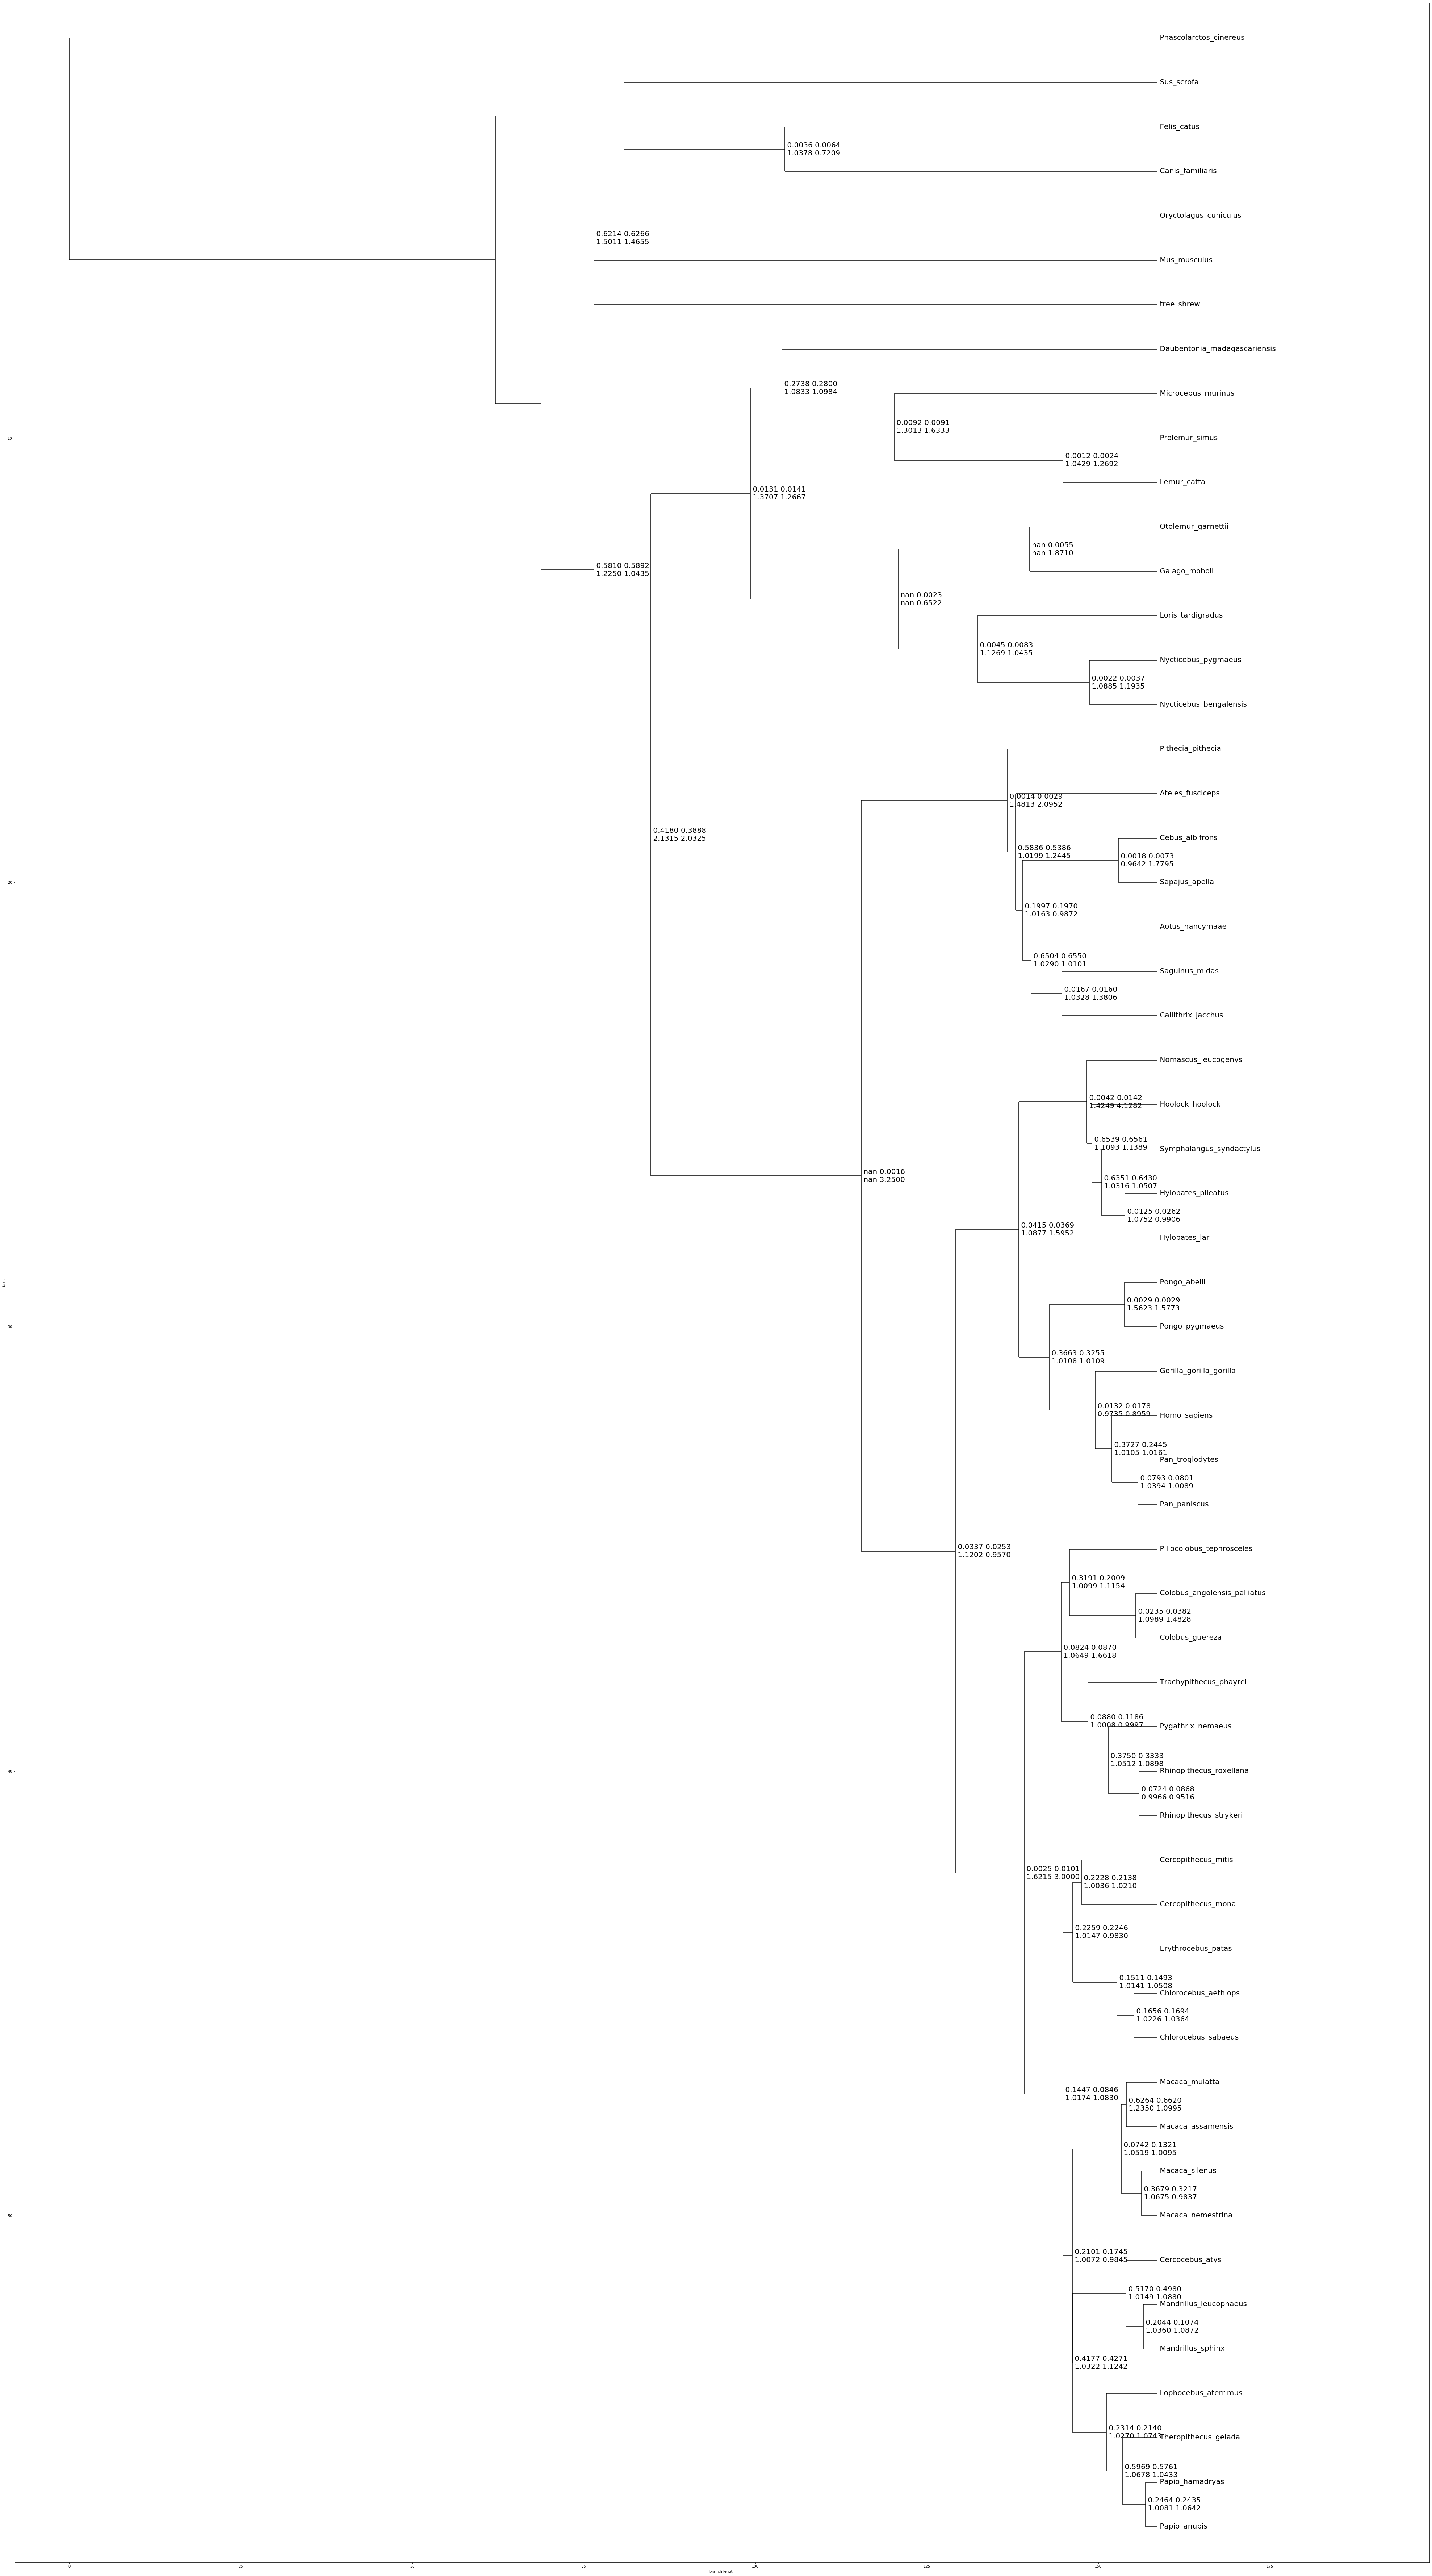

In [13]:

fig= plt.figure(figsize=(70,130))
axes = fig.add_subplot(1, 1, 1)
matplotlib.rc('font', size=20)
Phylo.draw(tree, axes=axes, label_func=extract_label, show_confidence=False, do_show=False)
plt.savefig('../plots/line_plot.pdf') 

['Canis_familiaris Felis_catus Sus_scrofa Macaca_mulatta', 'Mus_musculus Oryctolagus_cuniculus Macaca_mulatta Sus_scrofa', 'Macaca_mulatta tree_shrew Mus_musculus Sus_scrofa', 'Lemur_catta Macaca_mulatta tree_shrew Mus_musculus', 'Lemur_catta Nycticebus_bengalensis Macaca_mulatta tree_shrew', 'Nycticebus_bengalensis Otolemur_garnettii Lemur_catta Macaca_mulatta', 'Loris_tardigradus Nycticebus_bengalensis Otolemur_garnettii Lemur_catta', 'Nycticebus_bengalensis Nycticebus_pygmaeus Loris_tardigradus Otolemur_garnettii', 'Galago_moholi Otolemur_garnettii Nycticebus_bengalensis Lemur_catta', 'Daubentonia_madagascariensis Lemur_catta Nycticebus_bengalensis Macaca_mulatta', 'Lemur_catta Microcebus_murinus Daubentonia_madagascariensis Nycticebus_bengalensis', 'Lemur_catta Prolemur_simus Microcebus_murinus Daubentonia_madagascariensis', 'Macaca_mulatta Saguinus_midas Lemur_catta tree_shrew', 'Pithecia_pithecia Saguinus_midas Macaca_mulatta Lemur_catta', 'Ateles_fusciceps Saguinus_midas Pitheci

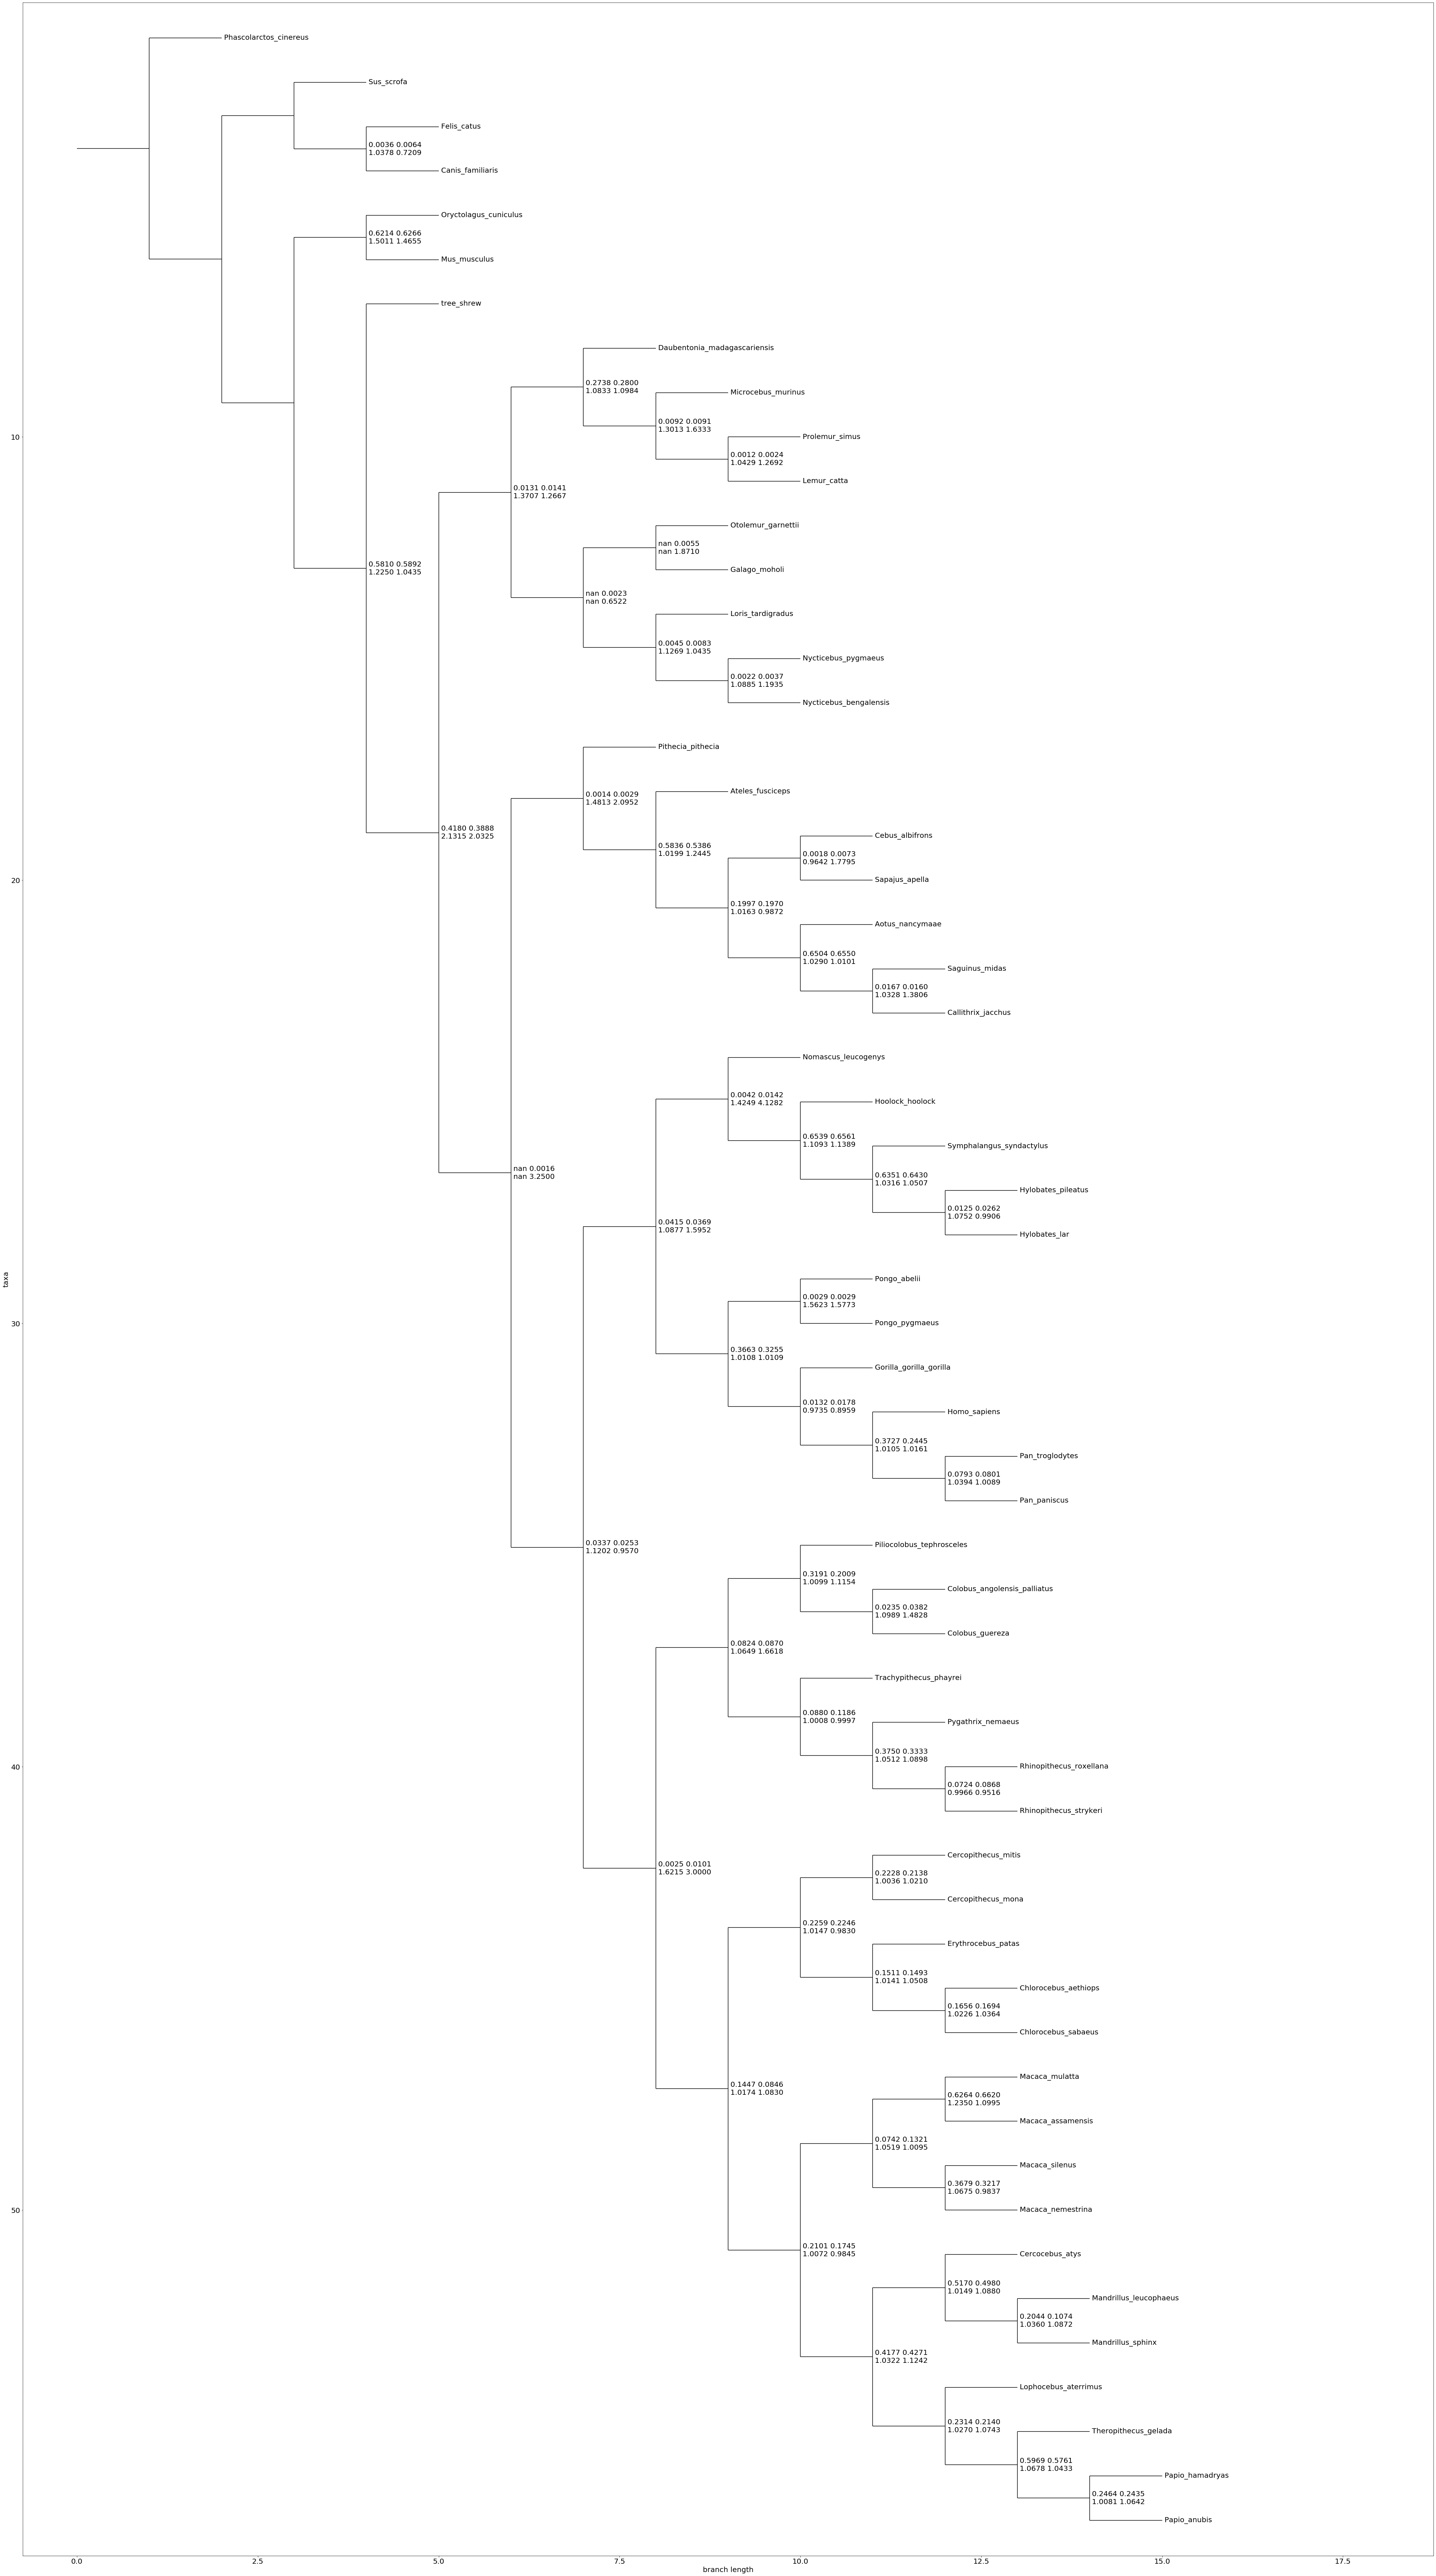

In [22]:
# Load the tree
tree2 = PhyloXMLIO.read('../results/tree.xml')[0]

tree2 = tag_tree(tree2)

for clade in tree2.find_clades():
    clade.branch_length = 1
    
tree2.ladderize()

fig= plt.figure(figsize=(70,130))
axes = fig.add_subplot(1, 1, 1)
matplotlib.rc('font', size=20)
Phylo.draw(tree2, axes=axes, label_func=extract_label, show_confidence=False)